In [1]:
import vof
from vof import forecaster
from vof import optimizer

SyntaxError: invalid syntax (forecaster.py, line 120)

In [ ]:
pip install --use-deprecated=legacy-resolver pycaret-ts-alpha

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
import random
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from datetime import date
import nevergrad as ng

plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

In [3]:
data = pd.read_csv("data/district/predictions_2019.csv", index_col=0, parse_dates=True)#pd.read_csv('sales_FOODS_3_090_TX_2.csv')
data.head(5)

,Prophet 30d,CB Model 30d,Prophet 60d,LR Model 240d,LR Model 30d,LR Model 60d,LR Model 120d,Prophet 120d,Theta 30d,Theta 60d,Theta 120d,Theta 240d,CB Model 60d,CB Model 240d,CB Model 120d,Prophet 240d,Fact,SNaive
Time,,,,,,,,,,,,,,,,,,
2019-01-02 00:00:00,9.712369,9.516061,9.732844,10.082039,10.034193,9.860739,9.931228,9.475604,9.992034,9.986460,10.074619,10.037784,9.478454,9.477245,9.469355,9.521947,9.791285,9.587180
2019-01-02 01:00:00,9.537794,9.329764,9.526740,9.905469,9.848606,9.685257,9.755594,9.250441,9.799050,9.784246,9.843274,9.809841,9.314212,9.310756,9.320833,9.283847,9.595427,9.421677
2019-01-02 02:00:00,9.346844,9.225298,9.357172,9.752310,9.685450,9.537204,9.604944,9.048528,9.646126,9.618324,9.656499,9.620984,9.217455,9.230141,9.192942,9.021519,9.538146,9.302606
2019-01-02 03:00:00,9.238202,9.140338,9.258282,9.633302,9.547768,9.422706,9.488390,8.965614,9.534998,9.506044,9.530117,9.501419,9.155913,9.161070,9.141137,8.909141,9.420105,9.151197
2019-01-02 04:00:00,9.222486,9.122567,9.222533,9.600721,9.502948,9.403288,9.459666,8.902531,9.499663,9.469673,9.476750,9.455269,9.125739,9.136762,9.136573,8.850692,9.364424,9.159970


# Creating forecast from Fact data

We start with creating a forecaster oblect from data['Fact'] with target mentric (the one to predict) also equal to 'Fact'

In [4]:
tmp = forecaster.RecursiveForecaster(data[['Fact']], 
                          target='Fact')
tmp.y

Time
2019-01-02 00:00:00     9.791285
2019-01-02 01:00:00     9.595427
2019-01-02 02:00:00     9.538146
2019-01-02 03:00:00     9.420105
2019-01-02 04:00:00     9.364424
                         ...    
2019-12-31 19:00:00    12.082850
2019-12-31 20:00:00    11.582850
2019-12-31 21:00:00    11.257850
2019-12-31 22:00:00    10.887850
2019-12-31 23:00:00    10.482850
Name: Fact, Length: 8736, dtype: float64

## Estimating Lags and adding them to the object

In [5]:
def estimateSignificantLags(ts, nlags = 360, significantLags = 11): 
    pacf = sm.tsa.stattools.pacf(ts, nlags)
    lags = np.argsort(-np.abs(pacf))[1:significantLags+1]
    plt.plot(pacf,'*--')
    plt.plot(lags,pacf[lags],'o')
    return lags

[  1   2   3   5  23  24  26  50 168 169]


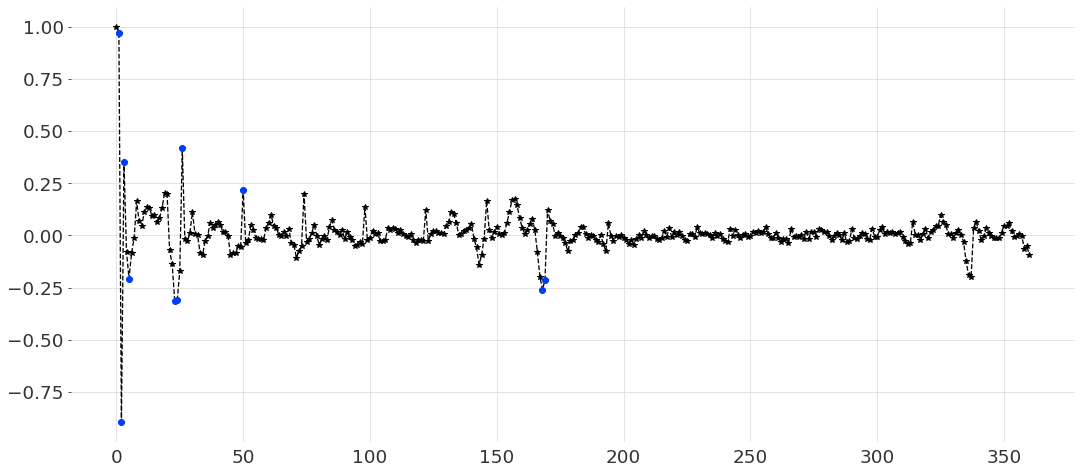

In [6]:
lags = estimateSignificantLags(tmp.y, significantLags = 10)
# add lags for certain days
lags = np.unique(np.hstack([lags]))
print(np.sort(lags))

In [7]:
tmp.add_lag_features(np.sort(lags))

In [8]:
tmp.x.head(5)

,lag_1,lag_2,lag_3,lag_5,lag_23,lag_24,lag_26,lag_50,lag_168,lag_169
Time,,,,,,,,,,
2019-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02 01:00:00,9.791285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02 02:00:00,9.595427,9.791285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02 03:00:00,9.538146,9.595427,9.791285,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02 04:00:00,9.420105,9.538146,9.595427,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Now the dataset is ready, so we can start building a dataframe with different predictions for further optimization.
All predictions will be in the same dataframe optimization_df together with the Fact data.
We run several prediction models

In [9]:
optimization_df = pd.DataFrame(tmp.y, columns=['Fact'])

models = {'LR': linear_model.LinearRegression(),
          'CB': CatBoostRegressor(verbose=False,learning_rate = 0.01,depth=6,l2_leaf_reg=4),
          'RF': RandomForestRegressor(),
          'LGBM': lgb.LGBMRegressor() }

for model in models.keys():
    optimization_df[model] = tmp.create_prediction(models[model],
                      start_day='2019-01-12',
                      last_known_day='2019-03-01',
                      prediction_day='2019-03-02',
                      frequency='H',
                      horizon=720)

LinearRegression()
RandomForestRegressor()
LGBMRegressor()


In [12]:
optimization_df = optimization_df.dropna()
optimization_df

,Fact,LR,CB,RF,LGBM
Time,,,,,
2019-03-02 00:00:00,10.947910,10.933568,10.898989,10.888299,10.902972
2019-03-02 01:00:00,10.730205,10.737524,10.666039,10.6709,10.676169
2019-03-02 02:00:00,10.498403,10.547683,10.526944,10.522914,10.554631
2019-03-02 03:00:00,10.372299,10.371807,10.393229,10.34858,10.347762
2019-03-02 04:00:00,10.365991,10.369586,10.347148,10.331267,10.377326
...,...,...,...,...,...
2019-03-31 19:00:00,10.896059,10.884811,10.843793,10.895342,10.873305
2019-03-31 20:00:00,10.887494,10.856856,10.810256,10.874265,10.890975
2019-03-31 21:00:00,10.868426,10.807409,10.790033,10.789015,10.869045


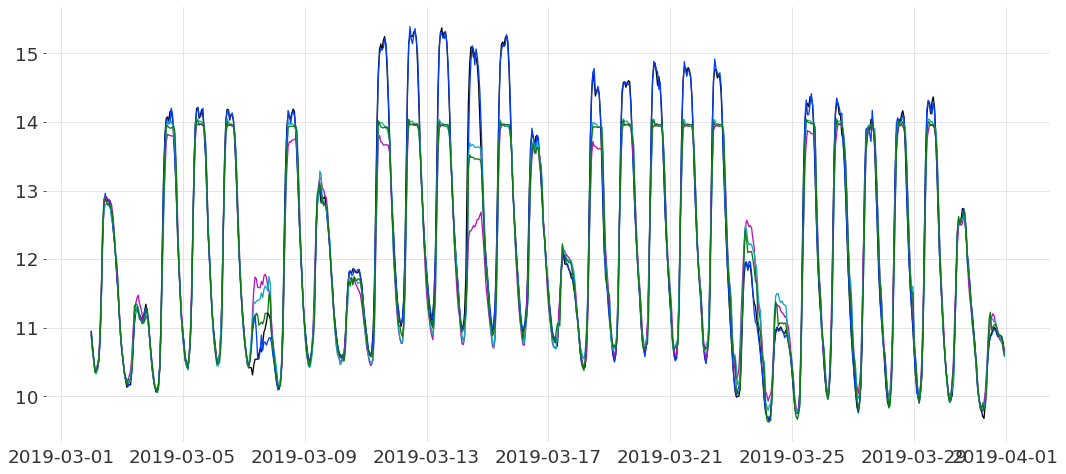

In [14]:
plt.plot(optimization_df['Fact'])
plt.plot(optimization_df['LR'])
plt.plot(optimization_df['CB'])
plt.plot(optimization_df['RF'])
plt.plot(optimization_df['LGBM'])

# Optimizer to choose from several predictions

Predictions are ready. Now we are creating a child class for Electricity Peak Case. 
We need the child class to pass there task-specific cost functions and other constant values like PEAK_POWER_LIMIT, BATTERY_CHARGE, BATTERY_CAPACITY end so on

In [35]:
class OptimalDecisionMakersElectricityPeak(optimizer.OptimalDecisionMakers):
    


    def __init__(self, data, target):
        super().__init__(data, target)
        self.EVALUATE = False
        self.TIME_HORIZON = 168
        self.DECISION_TIMESTEP = 24
        self.PEAK_POWER_LIMIT = 12
        self.BATTERY_CHARGE = 0
        self.BATTERY_CAPACITY = 1000
        self.BATTERY_EFFICIENCY = .99
        
    def cost_function(self,solution):
        
        cumsum = np.cumsum(solution) + self.BATTERY_CHARGE

        #battery capacity penalty:
        violations_battery = (np.sum(np.where(cumsum>self.BATTERY_CAPACITY)) + np.sum(np.where(cumsum<0))) * 10000

        #penalty for putting electricity back to the grid
        if self.EVALUATE:
            grid_load = (self.y+solution).values
        else:
            grid_load = (self.candidate+solution).values
        violations_demand = -np.sum(grid_load[np.where(grid_load<0)]) * 10000

        #penlty for high peak in load
        margin = (self.PEAK_POWER_LIMIT - grid_load)
        violations_peak = - np.sum(margin[np.where(margin < 0)]) * 1000

        #penalty for battery losses
        battery_usage = (1 - self.BATTERY_EFFICIENCY) * np.sum(np.abs(solution)) * 1000

        total_cost = violations_battery + violations_demand + violations_peak + battery_usage
        #print(violations_battery,violations_demand,violations_peak,battery_usage)
        return total_cost
    
    def calculate_optimal_decision(self, col):
        
        print(col)
        
        total_steps = range(0,len(self.x)-self.TIME_HORIZON,self.DECISION_TIMESTEP)
        recommendation = np.array([])
        battery_charge = self.BATTERY_CHARGE

        for step in total_steps:

            par = ng.p.Array(shape=(self.TIME_HORIZON,)).set_bounds(lower=-80, upper=80)
            optimizer = ng.optimizers.CMA(parametrization=par, budget=30000)

            try:
                self.candidate = self.x.iloc[step:step+self.TIME_HORIZON,col]
            except:
                print(self.optimal_decisions_df.shape)
                print(self.x.iloc[step:step+self.TIME_HORIZON,col])

            step_recommendation = optimizer.minimize(self.cost_function)
            recommendation = np.append(recommendation,step_recommendation.value[0:self.DECISION_TIMESTEP])
            battery_charge = battery_charge + sum(step_recommendation.value[0:self.DECISION_TIMESTEP])

        battery_charge = 0
        
        return pd.Series(name=col, data=recommendation)
    
    def select_value_optimal_model(self,return_predictions=False):
        
        random.seed(42)
        
        self.optimal_decisions_df = pd.DataFrame(index=(self.x.index),columns=self.x.columns).iloc[:-self.TIME_HORIZON]
        
        parallel_optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(col) for col in range(len(self.optimal_decisions_df.columns))))
        
        for i in parallel_optimal_decision_result:
            self.optimal_decisions_df.iloc[:,i.name] = i.values

        return self.optimal_decisions_df
    
    def evaluate(self):
        
        for col in range(len(self.optimal_decisions_df.columns)):
            
            cost_evaluation = (self.optimal_decisions_df.iloc[:,col]+self.x.Fact)[(self.optimal_decisions_df.iloc[:,col]+self.x.Fact)>12].sum()
            print(col, cost_evaluation)
        return #cost_evaluation
        
    def select_value_optimal_hyperparameters():
        return

## Now just creating an oblect of this child class using optimization_df from the previous steps

In [36]:
odm = OptimalDecisionMakersElectricityPeak(optimization_df,'Fact')

In [37]:
odm.x

,Fact,LR,CB,RF,LGBM
Time,,,,,
2019-03-02 00:00:00,10.947910,10.933568,10.898989,10.888299,10.902972
2019-03-02 01:00:00,10.730205,10.737524,10.666039,10.6709,10.676169
2019-03-02 02:00:00,10.498403,10.547683,10.526944,10.522914,10.554631
2019-03-02 03:00:00,10.372299,10.371807,10.393229,10.34858,10.347762
2019-03-02 04:00:00,10.365991,10.369586,10.347148,10.331267,10.377326
...,...,...,...,...,...
2019-03-31 19:00:00,10.896059,10.884811,10.843793,10.895342,10.873305
2019-03-31 20:00:00,10.887494,10.856856,10.810256,10.874265,10.890975
2019-03-31 21:00:00,10.868426,10.807409,10.790033,10.789015,10.869045


## Running optimization to select the optimal model

In [38]:
from joblib import Parallel, delayed

sol = odm.select_value_optimal_model()
sol

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 10.1min remaining: 15.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 10.1min remaining:  6.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.2min finished


,Fact,LR,CB,RF,LGBM
Time,,,,,
2019-03-02 00:00:00,0.910814,0.954408,1.036285,1.106160,0.915556
2019-03-02 01:00:00,1.181764,1.216570,1.145773,1.137649,1.133885
2019-03-02 02:00:00,1.476139,1.279263,1.190132,1.460594,1.152763
2019-03-02 03:00:00,1.560507,1.546970,1.406422,1.448557,1.506766
2019-03-02 04:00:00,1.256494,1.618984,1.545031,1.508080,1.586132
...,...,...,...,...,...
2019-03-24 19:00:00,0.978312,1.027855,0.690904,0.567096,0.672521
2019-03-24 20:00:00,1.033653,0.725329,0.891171,0.920089,1.103027
2019-03-24 21:00:00,1.068472,1.200168,0.879133,1.072588,0.944924


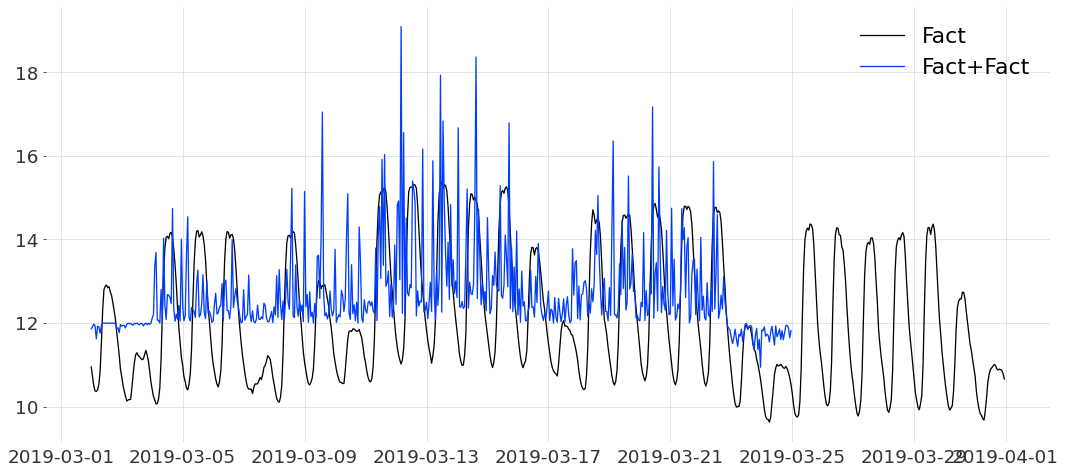

In [41]:
#plt.plot(sol.SNaive, label='solution')

plt.plot(odm.x.Fact, label='Fact')

plt.plot(sol['Fact']+odm.x.Fact, label='Fact+Fact')
# plt.plot(sol['LR']+odm.x.Fact, label='LR+Fact')
# plt.plot(sol['CB']+odm.x.Fact, label='CB+Fact')
# plt.plot(sol['RF']+odm.x.Fact, label='RF+Fact')
# plt.plot(sol['LGBM']+odm.x.Fact, label='LGBM+Fact')

plt.legend()

## Evaluation returns outputs of cost function for each of the models:

In [29]:
EVALUATE = True
print(odm.x.columns, odm.evaluate())

0 5398.72042815205
1 5307.2510836031925
2 4891.784067911722
3 4839.313320373836
4 4934.334599641056
Index(['Fact', 'LR', 'CB', 'RF', 'LGBM'], dtype='object') None
